In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import time


In [2]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


In [3]:

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


In [4]:

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [5]:

def ResNet50(num_classes, in_channel=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, in_channel=in_channel)


In [ ]:

class ResNetISLClassifier:
    def __init__(self, data_dir, device=None):
        self.data_dir = data_dir
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.setup_datasets()
        self.model = ResNet50(num_classes=len(self.train_dataset.classes)).to(self.device)
        self.best_acc = 0.0
        self.class_names = self.train_dataset.classes

    def setup_datasets(self):
        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "train"), transform=self.train_transforms)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "valid"), transform=self.val_transforms)
        self.test_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "test"), transform=self.val_transforms) if os.path.exists(os.path.join(self.data_dir, "test")) else None

        self.train_loader = DataLoader(self.train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=False)
        self.val_loader = DataLoader(self.val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=False)
        if self.test_dataset:
            self.test_loader = DataLoader(self.test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    def train(self, num_epochs=15, lr=0.001, save_path="best_resnet50_model.pth"):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        for epoch in range(num_epochs):
            self.model.train()
            running_loss, correct = 0.0, 0
            for inputs, labels in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

            epoch_loss = running_loss / len(self.train_dataset)
            epoch_acc = correct / len(self.train_dataset)

            val_acc = self.evaluate()
            scheduler.step()

            if val_acc > self.best_acc:
                self.best_acc = val_acc
                torch.save(self.model.state_dict(), save_path)
                print(f" Best model saved with accuracy: {val_acc:.4f}")

            print(f"Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}, Val Acc={val_acc:.4f}")

    def evaluate(self):
        self.model.eval()
        correct = 0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                correct += (outputs.argmax(1) == labels).sum().item()
        acc = correct / len(self.val_dataset)
        return acc


# Cell 3: Main Entry
if __name__ == "__main__":
    data_dir = r"E:\\New folder\\isl_inverted"
    classifier = ResNetISLClassifier(data_dir)
    classifier.train(num_epochs=15, lr=0.001, save_path="res.pth")


In [12]:
import gc
torch.cuda.empty_cache()
gc.collect()


0

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
import random
from tqdm import tqdm


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Force CUDA errors to appear at the right line

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from PIL import Image


class ResNet50ISLClassifier:
    def __init__(self, data_dir, device=None):
        self.data_dir = data_dir
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = 8
        self.num_workers = 4

        # Load default pretrained weights and transforms
        self.weights = ResNet50_Weights.DEFAULT
        self.transforms = self.weights.transforms()

        # Apply transforms
        self.train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            self.transforms
        ])
        self.val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            self.transforms
        ])

        # Load data
        self.setup_datasets()
        self.model = self.create_model()
        self.best_acc = 0.0
        self.class_names = self.train_dataset.classes

        print(f"✅ ResNet-50 initialized on {self.device}")
        print(f"Classes: {len(self.class_names)}")
        print(f"Train: {len(self.train_dataset)} | Valid: {len(self.val_dataset)}")

    def setup_datasets(self):
        self.train_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, "train"), transform=self.train_transforms)
        self.val_dataset = datasets.ImageFolder(
            os.path.join(self.data_dir, "valid"), transform=self.val_transforms)

        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                                       num_workers=self.num_workers, pin_memory=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                                     num_workers=self.num_workers, pin_memory=True)

    def create_model(self):
        model = resnet50(weights=self.weights)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(self.train_dataset.classes))
        return model.to(self.device)

    def train(self, num_epochs=20, learning_rate=0.001, save_path="best_resnet50_model.pth"):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        train_losses, train_accuracies, val_accuracies = [], [], []

        for epoch in range(20):
            start_time = time.time()
            self.model.train()
            running_loss = 0.0
            correct = 0

            loop = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for inputs, labels in loop:
                try:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    preds = outputs.argmax(dim=1)
                    correct += torch.sum(preds == labels.data)

                    loop.set_postfix(loss=loss.item(), acc=correct.item() / len(self.train_dataset))
                except Exception as e:
                    print(f"❌ Error in training batch: {e}")
                    continue

            epoch_loss = running_loss / len(self.train_dataset)
            epoch_acc = correct.double() / len(self.train_dataset)
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())

            # Validation
            self.model.eval()
            val_correct = 0
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    preds = outputs.argmax(dim=1)
                    val_correct += torch.sum(preds == labels.data)

            val_acc = val_correct.double() / len(self.val_dataset)
            val_accuracies.append(val_acc.item())
            scheduler.step()

            print(f"[{epoch+1}] Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f} | Time: {time.time() - start_time:.2f}s")

            if val_acc > self.best_acc:
                self.best_acc = val_acc
                torch.save({
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'class_names': self.class_names
                }, save_path)
                print(f"🎯 New best model saved: {save_path}")

        self.plot_history(train_losses, train_accuracies, val_accuracies)

    def plot_history(self, losses, train_accs, val_accs):
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        plt.plot(losses, label="Train Loss")
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label="Train Acc")
        plt.plot(val_accs, label="Val Acc")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig("training_history.png")
        plt.show()
        print("📊 Saved training plot as 'training_history.png'")

    def evaluate(self, model_path=None):
        if model_path:
            checkpoint = torch.load(model_path, map_location=self.device)
            self.model.load_state_dict(checkpoint["model_state_dict"])
            self.class_names = checkpoint["class_names"]

        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(self.val_loader, desc="Evaluating"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        acc = np.mean(np.array(all_preds) == np.array(all_labels))
        print(f"\n📊 Validation Accuracy: {acc:.4f}")
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=self.class_names))
        self.plot_confusion_matrix(all_labels, all_preds)

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig("confusion_matrix.png")
        plt.show()
        print("📊 Saved confusion matrix as 'confusion_matrix.png'")


# Optional utility to check corrupt images before training
def verify_images(folder):
    print(f"🔍 Checking for corrupt images in: {folder}")
    for root, _, files in os.walk(folder):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
            except Exception as e:
                print(f"❌ Corrupt image: {img_path} | Error: {e}")
                # os.remove(img_path)  # Uncomment if you want to delete bad files


📦 Make sure the following are installed:
pip install torch torchvision scikit-learn matplotlib seaborn tqdm
✅ ResNet-50 initialized on cuda
Classes: 30
Train: 2380 | Valid: 688


Epoch 1/20: 100%|██████████| 298/298 [01:01<00:00,  4.82it/s, acc=0.139, loss=3.99] 


[1] Train Loss: 3.1121 | Train Acc: 0.1387 | Val Acc: 0.1541 | Time: 79.47s
🎯 New best model saved: best_resnet50_model.pth


Epoch 2/20: 100%|██████████| 298/298 [01:01<00:00,  4.82it/s, acc=0.346, loss=2.44] 


[2] Train Loss: 2.3266 | Train Acc: 0.3462 | Val Acc: 0.4448 | Time: 79.69s
🎯 New best model saved: best_resnet50_model.pth


Epoch 3/20: 100%|██████████| 298/298 [01:02<00:00,  4.80it/s, acc=0.515, loss=2.63]  


[3] Train Loss: 1.6866 | Train Acc: 0.5147 | Val Acc: 0.6730 | Time: 79.77s
🎯 New best model saved: best_resnet50_model.pth


Epoch 4/20: 100%|██████████| 298/298 [01:01<00:00,  4.81it/s, acc=0.634, loss=1.92]  


[4] Train Loss: 1.2966 | Train Acc: 0.6336 | Val Acc: 0.8125 | Time: 80.13s
🎯 New best model saved: best_resnet50_model.pth


Epoch 5/20: 100%|██████████| 298/298 [01:03<00:00,  4.73it/s, acc=0.682, loss=0.863]  


[5] Train Loss: 1.1192 | Train Acc: 0.6824 | Val Acc: 0.8590 | Time: 81.04s
🎯 New best model saved: best_resnet50_model.pth


Epoch 6/20: 100%|██████████| 298/298 [01:03<00:00,  4.70it/s, acc=0.726, loss=0.0129]


[6] Train Loss: 0.9044 | Train Acc: 0.7265 | Val Acc: 0.8299 | Time: 81.53s


Epoch 7/20: 100%|██████████| 298/298 [01:03<00:00,  4.70it/s, acc=0.756, loss=0.754]  


[7] Train Loss: 0.8417 | Train Acc: 0.7559 | Val Acc: 0.9113 | Time: 81.86s
🎯 New best model saved: best_resnet50_model.pth


Epoch 8/20: 100%|██████████| 298/298 [01:03<00:00,  4.72it/s, acc=0.845, loss=0.411] 


[8] Train Loss: 0.5611 | Train Acc: 0.8454 | Val Acc: 0.9578 | Time: 81.30s
🎯 New best model saved: best_resnet50_model.pth


Epoch 9/20: 100%|██████████| 298/298 [01:03<00:00,  4.71it/s, acc=0.86, loss=0.147]   


[9] Train Loss: 0.4747 | Train Acc: 0.8597 | Val Acc: 0.9608 | Time: 81.28s
🎯 New best model saved: best_resnet50_model.pth


Epoch 10/20: 100%|██████████| 298/298 [01:03<00:00,  4.69it/s, acc=0.883, loss=0.117]  


[10] Train Loss: 0.4194 | Train Acc: 0.8828 | Val Acc: 0.9724 | Time: 81.82s
🎯 New best model saved: best_resnet50_model.pth


Epoch 11/20: 100%|██████████| 298/298 [01:03<00:00,  4.71it/s, acc=0.879, loss=0.146]  


[11] Train Loss: 0.4130 | Train Acc: 0.8790 | Val Acc: 0.9724 | Time: 81.38s


Epoch 12/20: 100%|██████████| 298/298 [01:02<00:00,  4.74it/s, acc=0.887, loss=0.278]  


[12] Train Loss: 0.3846 | Train Acc: 0.8874 | Val Acc: 0.9753 | Time: 80.44s
🎯 New best model saved: best_resnet50_model.pth


Epoch 13/20: 100%|██████████| 298/298 [01:02<00:00,  4.77it/s, acc=0.888, loss=0.619]  


[13] Train Loss: 0.3904 | Train Acc: 0.8882 | Val Acc: 0.9666 | Time: 81.05s


Epoch 14/20: 100%|██████████| 298/298 [01:02<00:00,  4.75it/s, acc=0.89, loss=0.0173]  


[14] Train Loss: 0.3742 | Train Acc: 0.8899 | Val Acc: 0.9695 | Time: 80.45s


Epoch 15/20: 100%|██████████| 298/298 [01:02<00:00,  4.77it/s, acc=0.908, loss=0.0592] 


[15] Train Loss: 0.3397 | Train Acc: 0.9084 | Val Acc: 0.9709 | Time: 80.20s


Epoch 16/20: 100%|██████████| 298/298 [01:02<00:00,  4.77it/s, acc=0.913, loss=0.491]   


[16] Train Loss: 0.2950 | Train Acc: 0.9134 | Val Acc: 0.9695 | Time: 80.15s


Epoch 17/20: 100%|██████████| 298/298 [01:02<00:00,  4.76it/s, acc=0.92, loss=0.61]     


[17] Train Loss: 0.2799 | Train Acc: 0.9202 | Val Acc: 0.9709 | Time: 80.42s


Epoch 18/20: 100%|██████████| 298/298 [01:03<00:00,  4.69it/s, acc=0.911, loss=0.488]  


[18] Train Loss: 0.3285 | Train Acc: 0.9109 | Val Acc: 0.9782 | Time: 81.87s
🎯 New best model saved: best_resnet50_model.pth


Epoch 19/20: 100%|██████████| 298/298 [01:03<00:00,  4.66it/s, acc=0.905, loss=0.0129] 


[19] Train Loss: 0.3347 | Train Acc: 0.9050 | Val Acc: 0.9753 | Time: 82.15s


Epoch 20/20: 100%|██████████| 298/298 [01:03<00:00,  4.69it/s, acc=0.903, loss=0.104]  


[20] Train Loss: 0.3395 | Train Acc: 0.9029 | Val Acc: 0.9666 | Time: 81.85s


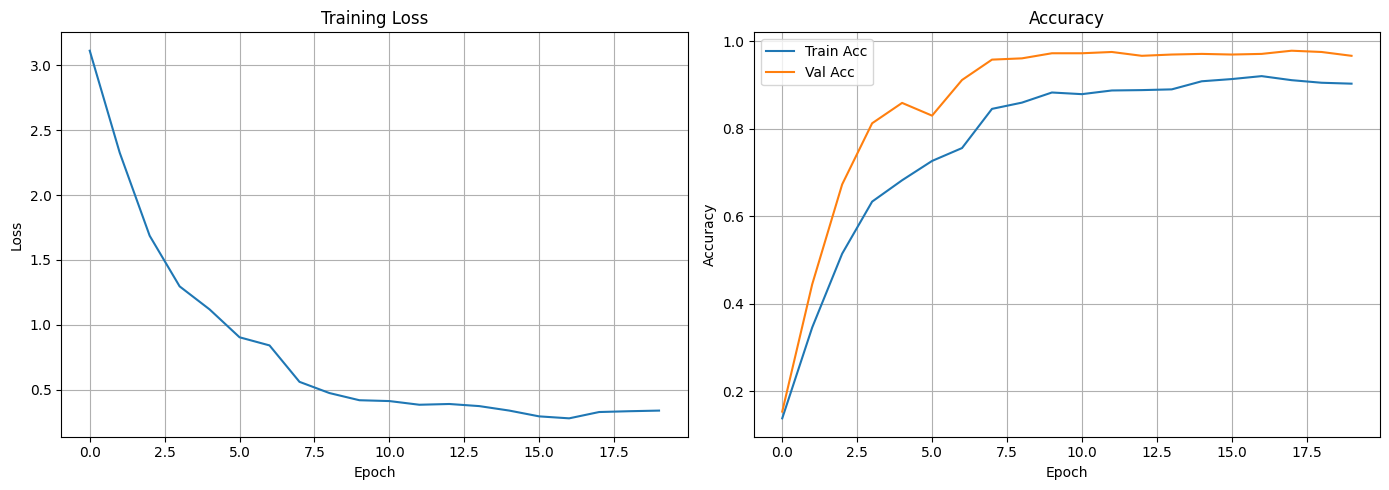

📊 Saved training plot as 'training_history.png'


Evaluating: 100%|██████████| 86/86 [00:18<00:00,  4.71it/s]



📊 Validation Accuracy: 0.9782

Classification Report:
              precision    recall  f1-score   support

   Beautiful       1.00      1.00      1.00        16
        Come       1.00      1.00      1.00        48
       Drink       0.84      1.00      0.91        16
         Eat       0.94      1.00      0.97        16
   Fine_Okay       1.00      1.00      1.00        20
      Friend       1.00      0.92      0.96        36
          Go       1.00      0.89      0.94        28
        Good       1.00      1.00      1.00        28
       Happy       1.00      1.00      1.00        20
 He_She_They       0.89      1.00      0.94        16
    Hello_Hi       1.00      1.00      1.00        20
        Help       1.00      1.00      1.00        24
         How       1.00      1.00      1.00        20
      Hungry       1.00      1.00      1.00        32
        I_Me       1.00      0.96      0.98        24
        Like       0.80      1.00      0.89        16
        Love       1.00   

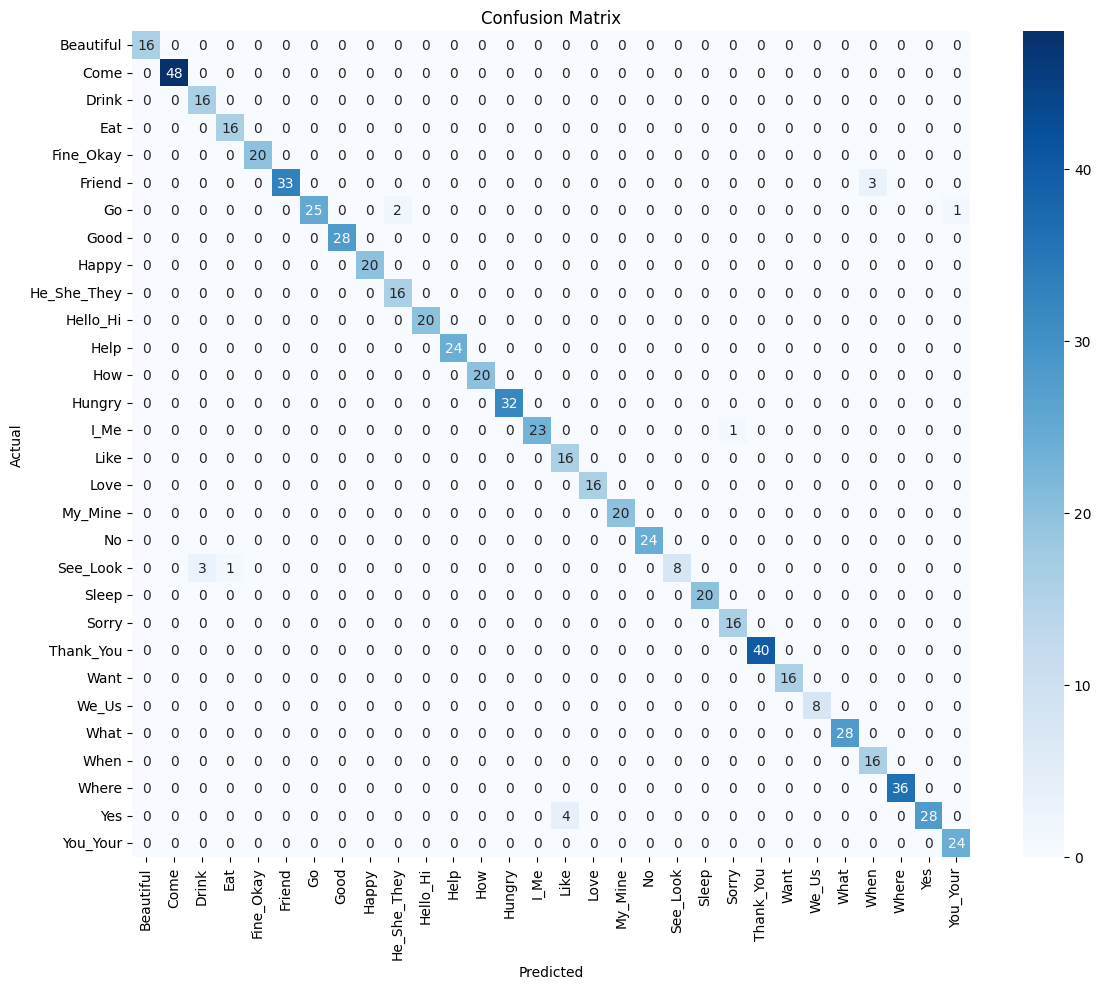

📊 Saved confusion matrix as 'confusion_matrix.png'


In [5]:


def main():
    data_dir = r"E:\New folder\isl_inverted"
    model_path = "best_resnet50_model.pth"

    classifier = ResNet50ISLClassifier(data_dir)
    classifier.train(num_epochs=20, learning_rate=0.001, save_path=model_path)
    classifier.evaluate(model_path=model_path)

if __name__ == "__main__":
    print("📦 Make sure the following are installed:")
    print("pip install torch torchvision scikit-learn matplotlib seaborn tqdm")
    main()


# Test 

In [6]:
import cv2
import torch
import mediapipe as mp
import numpy as np
from torchvision import models, transforms
from PIL import Image


In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Speed boost for fixed input sizes
print(f"Running on device: {device}")


Running on device: cuda


In [9]:
import torch
from torchvision import models

# Load pre-trained ResNet-50
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer
num_classes = 30
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


In [11]:

checkpoint = torch.load("best_resnet50_model.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device).eval()


In [12]:

class_names = checkpoint.get("class_names", [f"Class_{i}" for i in range(num_classes)])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils


In [13]:

def predict_hand(frame):
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        h, w, _ = frame.shape
        x_min, y_min, x_max, y_max = w, h, 0, 0

        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                x_min = min(x, x_min)
                y_min = min(y, y_min)
                x_max = max(x, x_max)
                y_max = max(y, y_max)

        
        pad = 30
        x_min = max(x_min - pad, 0)
        y_min = max(y_min - pad, 0)
        x_max = min(x_max + pad, w)
        y_max = min(y_max + pad, h)

        cropped_hand = frame[y_min:y_max, x_min:x_max]

        if cropped_hand.size == 0 or (x_max - x_min < 20 or y_max - y_min < 20):
            return None, 0.0

        pil_img = Image.fromarray(cv2.cvtColor(cropped_hand, cv2.COLOR_BGR2RGB))
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                outputs = model(input_tensor)
                probs = torch.nn.functional.softmax(outputs[0], dim=0)
                pred_index = torch.argmax(probs).item()
                confidence = probs[pred_index].item()

        return class_names[pred_index], confidence

    return None, 0.0


# on cam 


In [14]:

cap = cv2.VideoCapture(0)
print("✅ Webcam started. Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    pred_class, confidence = predict_hand(frame)

    if pred_class:
        text = f"{pred_class} ({confidence * 100:.1f}%)"
        color = (0, 255, 0)
    else:
        text = "No hand detected"
        color = (0, 0, 255)

    cv2.putText(frame, text, (10, 35), cv2.FONT_HERSHEY_SIMPLEX,
                1, color, 2, cv2.LINE_AA)

    cv2.imshow("ISL Real-Time", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


✅ Webcam started. Press 'q' to quit.


C:\Users\vedan\AppData\Local\Temp\ipykernel_19472\3634501321.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
